In [1]:
import pandas as pd

In [2]:
# 1. Load the risk mapping from the text file
risk_map = {}
with open(r"C:\Frank\UoT 2024-2025\MIE8888 Project\M13\risk_levels_RUIWU.txt", 'r') as f:
    for line in f:
        line = line.strip()
        # Skip headers and blank or separator lines
        if not line or line.startswith("procedure_code") or line.startswith("#####"):
            continue
        parts = line.split(',')
        if len(parts) == 2:
            code = parts[0].strip()
            try:
                risk = float(parts[1].strip())
            except ValueError:
                risk = 0.0
            risk_map[code] = risk

In [ ]:
risk_map

{'11117': -2.0,
 '11119': -3.0,
 '1205.0': 6.0,
 '11115': -2.0,
 '11116': -2.0,
 '12111': -1.0,
 '12112': -1.0,
 '12113': -2.0,
 '13211': -2.0,
 '13212': -3.0,
 '13401': -3.0,
 '13409': -2.0,
 '13411': -2.0,
 '13419': -2.0,
 '13601': 2.0,
 '13609': 3.0,
 '14101': 1.0,
 '14102': 1.0,
 '14502': 0.0,
 '14611': 2.0,
 '14612': 2.0,
 '14621': 1.0,
 '15101': 4.0,
 '15201': 3.0,
 '15602': 2.0,
 '15604': 2.0,
 '16101': 0.0,
 '16102': 1.0,
 '16201': 1.0,
 '16202': 2.0,
 '16401': 1.0,
 '16511': 3.0,
 '21215': 3.0,
 '21214': 2.0,
 '21213': 2.0,
 '21212': 1.0,
 '21211': 0.0,
 '21221': 1.0,
 '21301.0': 5.0,
 '21302.0': 5.0,
 '21401.0': 4.0,
 '21402.0': 4.0,
 '21403.0': 4.0,
 '21404.0': 4.0,
 '23101.0': 1.0,
 '23102.0': 2.0,
 '23111.0': 3.0,
 '23311': -2.0,
 '23312': -3.0,
 '23313': -3.0,
 '23314': -3.0,
 '42107': 3.0,
 '42108': 3.0,
 '42110': 4.0,
 '42209': 5.0,
 '42210': 6.0,
 '42211': 5.0,
 '42212': 6.0,
 '42213': 6.0,
 '42214': 7.0,
 '42215': 8.0,
 '42216': 8.0,
 '25781': -3.0,
 '25782': -3.0,
 '

In [4]:
# 2. Load the full patient data from CSV
# df = pd.read_csv(r"C:\Frank\UoT 2024-2025\MIE8888 Project\Data\Complete Data\21_treatements_backup_joined_patients_procedure_na_removed.csv")
df = pd.read_csv(r"C:\Frank\UoT 2024-2025\MIE8888 Project\Data\Complete Data\Mytestdataset.csv")
df['procedure_year'] = pd.to_datetime(df['procedure_date']).dt.year
df['age_at_filling'] = df['procedure_year'] - pd.to_datetime(df['birth_date']).dt.year

In [5]:
# 3. Map each treatment's procedure code to its risk value.
df['risk'] = df['procedure_code_y'].astype(str).map(risk_map)
# fill missing risk values with 0 (if any procedure code is not found in risk_map).
df['risk'] = df['risk'].fillna(0)

In [6]:
df.head()

,patient_id,birth_date,first_visit,last_visit,procedure_code_y,procedure_date,procedure_year,age_at_filling,risk
0,1,1955-06-10 00:00:00+00:00,1991-04-30T00:00:00,2013-04-30T00:00:00,1202,2004-04-19 00:00:00+00:00,2004,49.0,0.0
1,1,1955-06-10 00:00:00+00:00,1991-04-30T00:00:00,2013-04-30T00:00:00,11101,2004-04-19 00:00:00+00:00,2004,49.0,0.0
2,1,1955-06-10 00:00:00+00:00,1991-04-30T00:00:00,2013-04-30T00:00:00,11111,2004-04-19 00:00:00+00:00,2004,49.0,0.0
3,1,1955-06-10 00:00:00+00:00,1991-04-30T00:00:00,2013-04-30T00:00:00,12101,2004-04-19 00:00:00+00:00,2004,49.0,0.0
4,1,1955-06-10 00:00:00+00:00,1991-04-30T00:00:00,2013-04-30T00:00:00,42311,2007-07-11 00:00:00+00:00,2007,52.0,0.0


In [7]:
# Get a txt doc of procedure_code with 0 risk level
zero_risk_procedure_codes = []
for i, r in enumerate(df['risk']):
    if r == 0:
        zero_risk_procedure_codes.append(df['procedure_code_y'][i])

with open("zero_risk_procedure_codes.txt", "w") as file:
    for code in zero_risk_procedure_codes:
        file.write(str(code) + "\n")

In [8]:
# Get a txt doc of procedure_code with 0 risk level
non_zero_risk_procedure_codes = []
for i, r in enumerate(df['risk']):
    if r != 0:
        non_zero_risk_procedure_codes.append(df['procedure_code_y'][i])

with open("non_zero_risk_procedure_codes.txt", "w") as file:
    for code in non_zero_risk_procedure_codes:
        file.write(str(code) + "\n")

In [33]:
# 4. Define a function to compute the final normalized risk for a single patient.
def compute_patient_risk(patient_df):
    # Determine the treatment timeline for the patient
    min_year = patient_df['procedure_year'].min()
    max_year = patient_df['procedure_year'].max()
    normalized_risks = []
    
    # Slide the window year by year from the first to the last treatment year.
    for current_year in range(min_year, max_year + 1):
        start_window = current_year - 5
        end_window = current_year + 2
        # Filter treatments that fall within the current window.
        window_df = patient_df[(patient_df['procedure_year'] >= start_window) & (patient_df['procedure_year'] <= end_window)]
        risk_sum = window_df['risk'].sum()
        # Normalize the risk sum to the 6-point scale.
        normalized_risk = risk_sum / 6
        normalized_risks.append(normalized_risk)
    
    # The final risk is the average of normalized risks from each window.
    if normalized_risks:
        final_risk = sum(normalized_risks) / len(normalized_risks)
    else:
        final_risk = 0
    return final_risk

In [34]:
patient_risks = df.groupby('patient_id').apply(compute_patient_risk)
patient_risk_df = patient_risks.reset_index()
patient_risk_df.columns = ['patient_id', 'final_risk']
print(patient_risk_df.head())

   patient_id  final_risk
0           1   -0.233333
1           2   -0.705128
2           3   -0.277778
3           4   -0.555556
4           5   -0.151515


C:\Users\frank\AppData\Local\Temp\ipykernel_47964\413853556.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_risks = df.groupby('patient_id').apply(compute_patient_risk)


In [35]:
patient_risk_df

,patient_id,final_risk
0,1,-0.233333
1,2,-0.705128
2,3,-0.277778
3,4,-0.555556
4,5,-0.151515
...,...,...
10851,13580,0.000000
10852,13583,0.000000
10853,13584,0.000000
10854,13586,0.000000


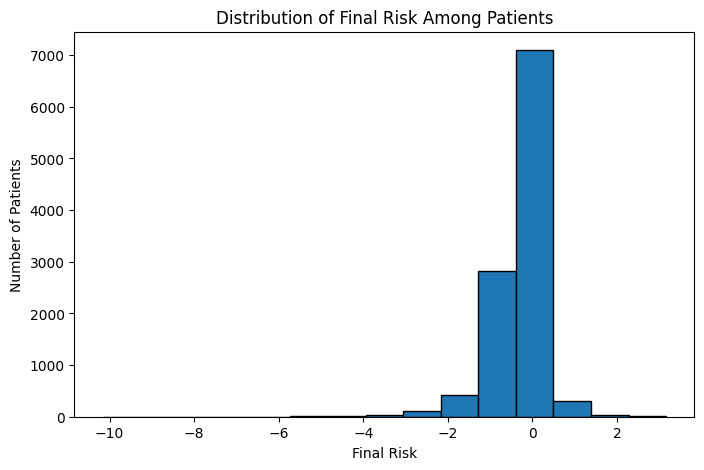

In [36]:
import matplotlib.pyplot as plt

# Plot a histogram of final risk
plt.figure(figsize=(8, 5))
plt.hist(patient_risk_df['final_risk'], bins=15, edgecolor='black')
plt.xlabel('Final Risk')
plt.ylabel('Number of Patients')
plt.title('Distribution of Final Risk Among Patients')
plt.show()

In [13]:
# n using those values to set data-driven thresholds for categorizing patients into Low, Medium, or High risk.
mean_risk = patient_risk_df['final_risk'].mean()
std_risk = patient_risk_df['final_risk'].std()

print("Mean Risk:", mean_risk)
print("Standard Deviation of Risk:", std_risk)

high_threshold = mean_risk + std_risk  # 1 SD above the mean
low_threshold = mean_risk - std_risk   # 1 SD below the mean

print("High Threshold:", high_threshold)
print("Low Threshold:", low_threshold)

Mean Risk: -0.32240513022674955
Standard Deviation of Risk: 0.6330291108248859
High Threshold: 0.31062398059813634
Low Threshold: -0.9554342410516354


In [14]:
# High_risk_patient_id = []
# for i, r in enumerate(patient_risk_df['final_risk']):
#     if r >= 4:
#         High_risk_patient_id.append(patient_risk_df['patient_id'][i])
# # with open("High_risk_patient_id.txt", "w") as file:
# #     for code in High_risk_patient_id:
# #         file.write(str(code) + "\n")

# Medium_risk_patient_id = []
# for i, r in enumerate(patient_risk_df['final_risk']):
#     if r <= 4 and r > 1:
#         Medium_risk_patient_id.append(patient_risk_df['patient_id'][i])
# # with open("Medium_risk_patient_id.txt", "w") as file:
# #     for code in Medium_risk_patient_id:
# #         file.write(str(code) + "\n")

# Low_risk_patient_id = []
# for i, r in enumerate(patient_risk_df['final_risk']):
#     if r <= 1:
#         Low_risk_patient_id.append(patient_risk_df['patient_id'][i])
# # with open("Low_risk_patient_id.txt", "w") as file:
# #     for code in Low_risk_patient_id:
# #         file.write(str(code) + "\n")

C:\Users\frank\AppData\Local\Temp\ipykernel_47964\3880658661.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=patient_risk_df, x='risk_category',


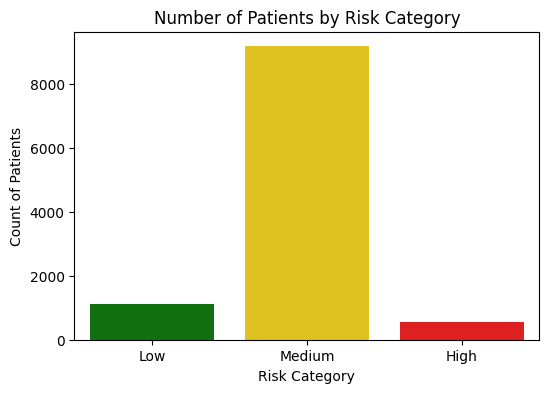

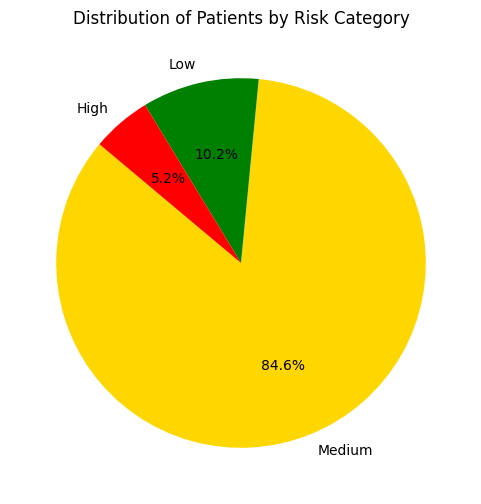

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def categorize_risk(r):
    if r > high_threshold:
        return 'High'
    elif r > low_threshold:
        return 'Medium'
    else:
        return 'Low'

patient_risk_df['risk_category'] = patient_risk_df['final_risk'].apply(categorize_risk)

# -------------------------------------
# Bar Chart of Risk Categories
# -------------------------------------
plt.figure(figsize=(6, 4))
sns.countplot(data=patient_risk_df, x='risk_category', 
              order=['Low', 'Medium', 'High'], 
              palette=['green','gold','red'])
plt.title('Number of Patients by Risk Category')
plt.xlabel('Risk Category')
plt.ylabel('Count of Patients')
plt.show()

# -------------------------------------
# Pie Chart of Risk Categories
# -------------------------------------
risk_counts = patient_risk_df['risk_category'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(risk_counts, 
        labels=risk_counts.index, 
        autopct='%1.1f%%', 
        startangle=140,
        colors=['gold','green','red'])
plt.title('Distribution of Patients by Risk Category')
plt.show()

---

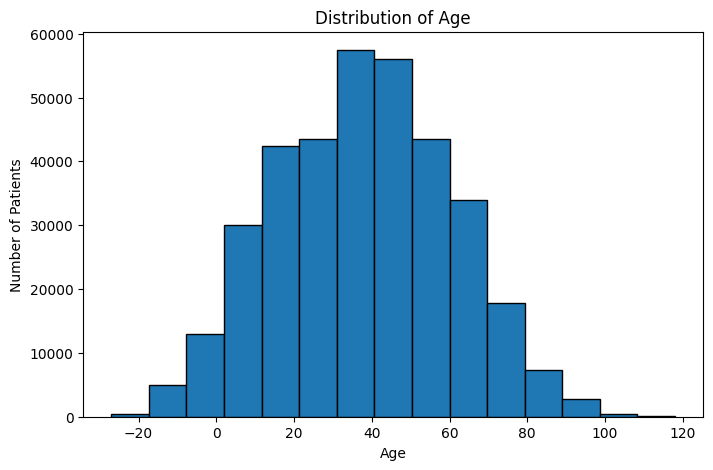

In [19]:
# Consider adding age as a variable for the risk level (age as a regulation term)
plt.figure(figsize=(8, 5))
plt.hist(df['age_at_filling'], bins=15, edgecolor='black')
plt.xlabel('Age')
plt.ylabel('Number of Patients')
plt.title('Distribution of Age')
plt.show()

In [ ]:
# Age follows a normal distribution
# mean_age = df['age_at_filling'].mean()
# std_age = df['age_at_filling'].std()

# print("Mean Risk:", mean_age)
# print("Standard Deviation of Risk:", std_age)

# high_threshold_age = mean_age + std_age  # 1 SD above the mean
# low_threshold_age = mean_age - std_age   # 1 SD below the mean

# print("High Threshold:", high_threshold_age)
# print("Low Threshold:", low_threshold_age)
# Not a good idea as children and elders are more likely to take serious treatments

Mean Risk: 37.700731578337134
Standard Deviation of Risk: 22.511946686424768
High Threshold: 60.212678264761905
Low Threshold: 15.188784891912366


In [ ]:
# def age_adjusted_risk(row):
#     base_risk = row['risk']
#     age = row['age_at_filling']
    
#     # Example piecewise approach based on common dental risk considerations
#     # (carries risk in pediatric patients, increasing periodontal/gum disease risk with age, 
#     #  more complex restorations and comorbidities in older adults, etc.)
    
#     if age < 18:
#         # Pediatric: higher risk of caries due to developing hygiene habits, diet, etc.
#         age_factor = 1  
#     elif 18 <= age < 30:
#         # Young adult: typically healthier gums, lower risk
#         age_factor = 0  
#     elif 30 <= age < 50:
#         # Early signs of periodontal issues, possible restorative work from earlier caries
#         age_factor = 1  
#     elif 50 <= age < 65:
#         # Increased risk of gum disease, dryness, and more complex restorative history
#         age_factor = 2  
#     elif 65 <= age < 80:
#         # Further increase in periodontal problems, root caries, possibly multiple comorbidities
#         age_factor = 3  
#     else:  # age >= 80
#         # Very elderly: frailty, significant restorative history, dry mouth (xerostomia), dexterity issues
#         age_factor = 4
#     return base_risk + age_factor

# def compute_patient_risk_adj(patient_df):
#     # Determine the treatment timeline for the patient
#     min_year = patient_df['procedure_year'].min()
#     max_year = patient_df['procedure_year'].max()
#     normalized_risks = []
    
#     # Slide the window year by year from the first to the last treatment year.
#     for current_year in range(min_year, max_year + 1):
#         start_window = current_year - 5
#         end_window = current_year + 2
#         # Filter treatments that fall within the current window.
#         window_df = patient_df[(patient_df['procedure_year'] >= start_window) & (patient_df['procedure_year'] <= end_window)]
#         window_df['adj_risk'] = window_df.apply(age_adjusted_risk, axis=1)
#         risk_sum = window_df['risk'].sum()
#         # Normalize the risk sum to the 6-point scale.
#         normalized_risk = risk_sum / 6
#         normalized_risks.append(normalized_risk)
    
#     # The final risk is the average of normalized risks from each window.
#     if normalized_risks:
#         final_risk = sum(normalized_risks) / len(normalized_risks)
#     else:
#         final_risk = 0
#     return final_risk


C:\Users\frank\AppData\Local\Temp\ipykernel_47964\1207905922.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_risks_adj = df.groupby('patient_id').apply(compute_patient_risk_adj)


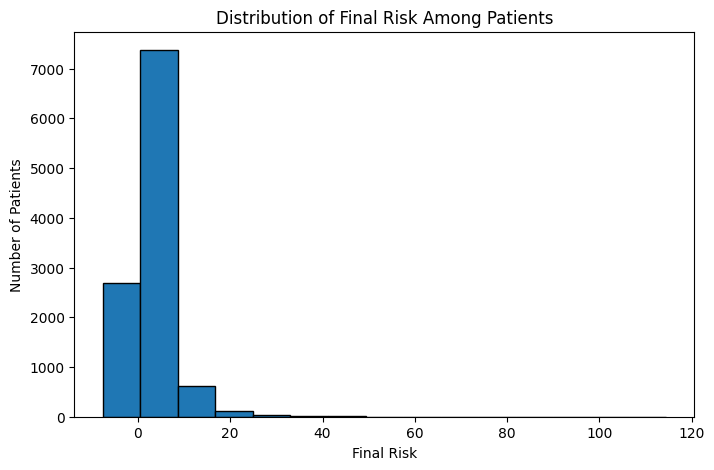

In [43]:
# Additive age factor
def compute_patient_risk_adj(patient_df):
    def age_adjusted_risk(row):
        base_risk = row['risk']
        age = row['age_at_filling']

        # Simple piecewise approach (you can modify these brackets/values)
        if age < 18:
            # Pediatric: higher risk of caries, orthodontic complications
            age_factor = 1
        elif 18 <= age < 30:
            # Young adult: typically lower additional risk
            age_factor = 0
        elif 30 <= age < 50:
            # Middle adult: early periodontal issues, existing restorations
            age_factor = 1
        elif 50 <= age < 65:
            # Pre-senior: increased risk of gum disease, dryness
            age_factor = 2
        elif 65 <= age < 80:
            # Senior adult: multiple restorations, possible comorbidities
            age_factor = 3
        else:  # age >= 80
            # Very elderly: frailty, significant restorative history, dry mouth
            age_factor = 4
        
        return base_risk + age_factor
    
    min_year = patient_df['procedure_year'].min()
    max_year = patient_df['procedure_year'].max()
    normalized_risks = []
    
    for current_year in range(min_year, max_year + 1):
        start_window = current_year - 5
        end_window = current_year + 2
        
        window_df = patient_df[(patient_df['procedure_year'] >= start_window) & (patient_df['procedure_year'] <= end_window)]
        
        # Apply the age-based adjustment to each row in this window
        window_df = window_df.copy()  # avoid SettingWithCopyWarning
        window_df['adj_risk'] = window_df.apply(age_adjusted_risk, axis=1)
        
        risk_sum = window_df['adj_risk'].sum()
        
        normalized_risk = risk_sum / 6
        normalized_risks.append(normalized_risk)
    
    if normalized_risks:
        final_risk = sum(normalized_risks) / len(normalized_risks)
    else:
        final_risk = 0
    
    return final_risk

patient_risks_adj = df.groupby('patient_id').apply(compute_patient_risk_adj)
patient_risk_df_adj = patient_risks_adj.reset_index()
patient_risk_df_adj.columns = ['patient_id', 'final_adj_risk']

# Plot a histogram of final risk
plt.figure(figsize=(8, 5))
plt.hist(patient_risk_df_adj['final_adj_risk'], bins=15, edgecolor='black')
plt.xlabel('Final Risk')
plt.ylabel('Number of Patients')
plt.title('Distribution of Final Risk Among Patients')
plt.show()

C:\Users\frank\AppData\Local\Temp\ipykernel_47964\1059553793.py:70: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  patient_risks_adj = df.groupby('patient_id').apply(compute_patient_risk_adj)


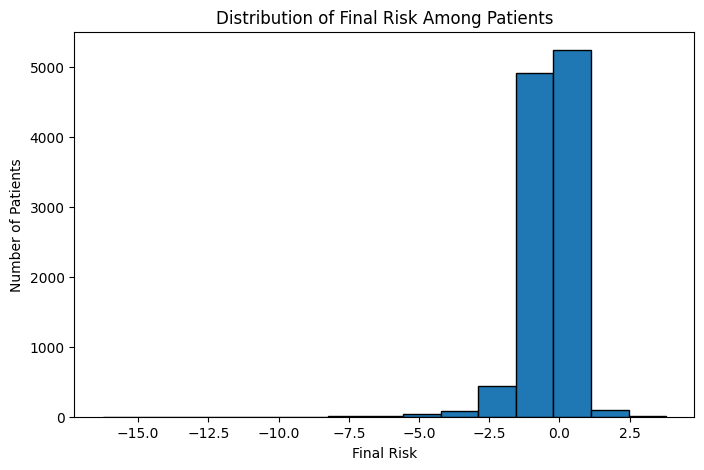

In [45]:
def compute_patient_risk_adj(patient_df):
    """
    Computes a final risk score for a single patient by:
      1. Sliding a window of (year-5) to (year+2) across each treatment year.
      2. Summing age-adjusted (multiplicative) risk scores within that window.
      3. Normalizing by dividing by 6.
      4. Averaging the normalized risk across all windows.
    """

    def age_adjusted_risk(row):
        base_risk = row['risk']
        age = row['age_at_filling']  # Make sure this column exists in your DataFrame

        # Example piecewise approach using multiplicative factors.
        # You can adjust these brackets/factors as needed.
        if age < 18:
            # Pediatric
            age_factor = 1.1
        elif 18 <= age < 30:
            age_factor = 1.0
        elif 30 <= age < 40:
            age_factor = 1.1
        elif 40 <= age < 50:
            age_factor = 1.2
        elif 50 <= age < 60:
            age_factor = 1.3
        elif 60 <= age < 70:
            age_factor = 1.4
        elif 70 <= age < 80:
            age_factor = 1.5
        else:  # age >= 80
            age_factor = 1.6

        return base_risk * age_factor

    # Determine the treatment timeline (integer years)
    min_year = patient_df['procedure_year'].min()
    max_year = patient_df['procedure_year'].max()
    normalized_risks = []
    
    # Slide the window year by year from the first to the last treatment year
    for current_year in range(min_year, max_year + 1):
        start_window = current_year - 5
        end_window = current_year + 2
        
        # Filter treatments within the current window
        window_df = patient_df[
            (patient_df['procedure_year'] >= start_window) &
            (patient_df['procedure_year'] <= end_window)
        ].copy()
        
        # Apply the age-based multiplicative adjustment
        window_df['adj_risk'] = window_df.apply(age_adjusted_risk, axis=1)
        
        # Sum the adjusted risk in this window
        risk_sum = window_df['adj_risk'].sum()
        
        # Normalize to a 6-point scale
        normalized_risk = risk_sum / 6
        normalized_risks.append(normalized_risk)
    
    # The final risk is the average of normalized risks from each window
    if normalized_risks:
        final_risk = sum(normalized_risks) / len(normalized_risks)
    else:
        final_risk = 0
    
    return final_risk

patient_risks_adj = df.groupby('patient_id').apply(compute_patient_risk_adj)
patient_risk_df_adj = patient_risks_adj.reset_index()
patient_risk_df_adj.columns = ['patient_id', 'final_adj_risk']

# Plot a histogram of final risk
plt.figure(figsize=(8, 5))
plt.hist(patient_risk_df_adj['final_adj_risk'], bins=15, edgecolor='black')
plt.xlabel('Final Risk')
plt.ylabel('Number of Patients')
plt.title('Distribution of Final Risk Among Patients')
plt.show()


Optimal λ for Box-Cox: 1.379027599528144


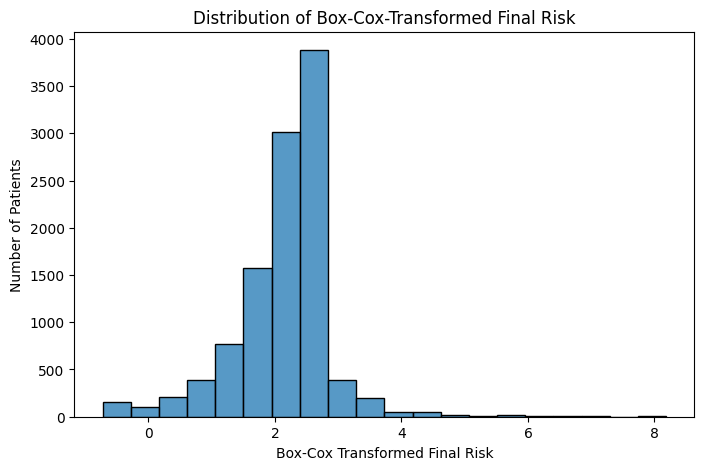

In [56]:
from scipy.stats import boxcox
# Box-Cox can help stabilize variance and make the distribution more symmetric.
# 1. Box-Cox requires strictly positive data. 
shift_amount = 3
shifted_final_risk = patient_risk_df['final_risk'] + shift_amount
shifted_final_risk = shifted_final_risk.clip(lower=1e-6)

# 2. Apply Box-Cox
# boxcox returns the transformed data and the lambda used
transformed, lam = boxcox(shifted_final_risk)

# 3. Store the Box-Cox-transformed final risk in the DataFrame
patient_risk_df['final_risk_boxcox'] = transformed
print(f"Optimal λ for Box-Cox: {lam}")

# 4. Plot the distribution of Box-Cox-transformed final risk
plt.figure(figsize=(8,5))
sns.histplot(patient_risk_df['final_risk_boxcox'], bins=20, edgecolor='black')
plt.xlabel('Box-Cox Transformed Final Risk')
plt.ylabel('Number of Patients')
plt.title('Distribution of Box-Cox-Transformed Final Risk')
plt.show()

Mean Risk: 2.146638967588639
Standard Deviation of Risk: 0.7656700857628356
High Threshold: 2.9123090533514744
Low Threshold: 1.3809688818258032


C:\Users\frank\AppData\Local\Temp\ipykernel_47964\2081024013.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=patient_risk_df, x='risk_category',


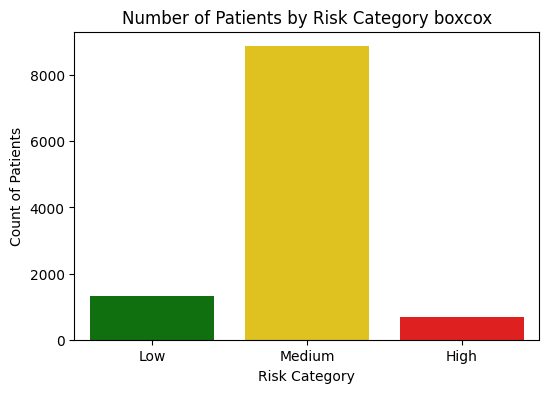

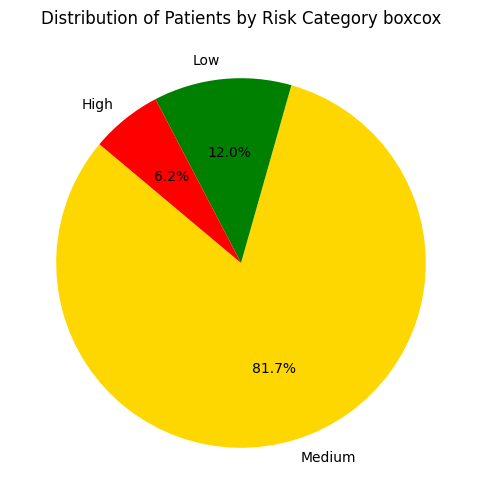

In [55]:
# n using those values to set data-driven thresholds for categorizing patients into Low, Medium, or High risk.
mean_risk = patient_risk_df['final_risk_boxcox'].mean()
std_risk = patient_risk_df['final_risk_boxcox'].std()

print("Mean Risk:", mean_risk)
print("Standard Deviation of Risk:", std_risk)

high_threshold = mean_risk + std_risk  # 1 SD above the mean
low_threshold = mean_risk - std_risk   # 1 SD below the mean

print("High Threshold:", high_threshold)
print("Low Threshold:", low_threshold)

def categorize_risk(r):
    if r > high_threshold:
        return 'High'
    elif r > low_threshold:
        return 'Medium'
    else:
        return 'Low'

patient_risk_df['risk_category'] = patient_risk_df['final_risk_boxcox'].apply(categorize_risk)

# -------------------------------------
# Bar Chart of Risk Categories
# -------------------------------------
plt.figure(figsize=(6, 4))
sns.countplot(data=patient_risk_df, x='risk_category', 
              order=['Low', 'Medium', 'High'], 
              palette=['green','gold','red'])
plt.title('Number of Patients by Risk Category boxcox')
plt.xlabel('Risk Category')
plt.ylabel('Count of Patients')
plt.show()

# -------------------------------------
# Pie Chart of Risk Categories
# -------------------------------------
risk_counts = patient_risk_df['risk_category'].value_counts()

plt.figure(figsize=(6,6))
plt.pie(risk_counts, 
        labels=risk_counts.index, 
        autopct='%1.1f%%', 
        startangle=140,
        colors=['gold','green','red'])
plt.title('Distribution of Patients by Risk Category boxcox')
plt.show()

Transforming risk level distribution to be more normal can offer several benefits in both analysis and interpretation:

* Many statistical tests and models (like t-tests, regression analyses, and ANOVA) assume normality. A normal distribution allows you to apply these methods more reliably.

* When the data are normally distributed, you can define risk thresholds (e.g., using mean ± 1 or 2 standard deviations) that have a clear probabilistic interpretation. This is useful for identifying outliers or high-risk patients. (in this case)

* In predictive modeling, transforming the risk levels to approximate normality can improve the performance of models that assume homoscedasticity (equal variance across the range) or linear relationships.
